In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", palette="Paired")

%load_ext autoreload
%autoreload 2

import numpy as np
import gym
import sys
import os
if "../" not in sys.path:
    sys.path.insert(0, "../")

    
from logger import *
setup_logging(default_level=logging.INFO)

from sklearn import manifold, datasets
from sklearn.utils import check_random_state


from algo.lstd import LSTDQ, LSTDMu, LSPI
from algo.policy import RandomPolicy2, LinearQ2
from algo.fa import LinearQ3
from algo.apprenticeship_learning import ApprenticeshipLearning as AL
from env.simulator import * 
from util.plotting import *
from util.basis import *


In [2]:
env_id = "MountainCar-v0"
env = gym.envs.make(env_id)
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
action_list = range(env.action_space.n)
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)
# default
s_init = [-0.5, 0]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
# hack to give us control over the initial state
import types

def new_timelimit_reset(self, s_init=None):
    import time
    self._episode_started_at = time.time()
    self._elapsed_steps = 0
    return self.env.reset(s_init)

def new_reset(self, s_init):
    if s_init is None:
        s_init = [np.random.uniform(-0.6, -0.4), 0]
    self.state = np.array(s_init)
    return np.array(self.state)
env.reset = types.MethodType(new_timelimit_reset, env)
env.env.reset = types.MethodType(new_reset, env.env)
print(env.reset([-.3, 0.3]))

[-0.3  0.3]


## obtain expert policy $\pi_{exp}$
- with linearly paramatized Q
- with radial basis function

In [4]:
include_action = False
# if this is True, then the state space becomes very large
# therefore, a more denser, higher number of phi is needed

p_linear = 2 * n_action
q_linear = 2 * n_action
phi_linear = LinearKernel2(p_linear, n_action, include_action).transform
psi_linear = phi_linear

n_component_list = [10, 10]
gamma_list = [0.5, 30.0]
#gamma_list = [0.5, 5.0, 30.0]
p_rbf =  int(np.sum(n_component_list)) * n_action
q_rbf = int(np.sum(n_component_list)) * n_action

# technically the truly-batch mode should use D to fit rbf kenel
states = np.array([env.observation_space.sample() for x in range(10000)])
phi_rbf = RBFKernel2(states, n_action, p_rbf, n_component_list, gamma_list, include_action).transform
psi_rbf = phi_rbf

precision = 1e-2
eps = 0.01
gamma = 0.99

n_component = 5
add_bias = True
standardized = True
p_gaus = (n_component**2 + int(add_bias)) * n_action
phi_gaus = GaussianKernel(states, n_action, p_gaus, n_component, include_action, add_bias, standardized).transform

/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Step 113 @ Episode 150/150 (-116.0)

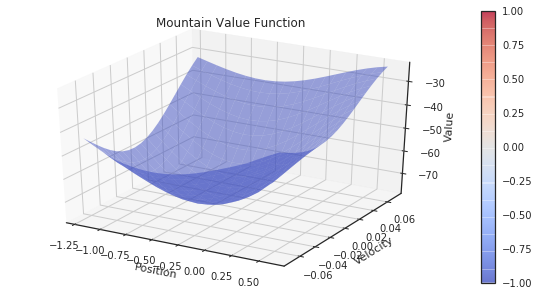

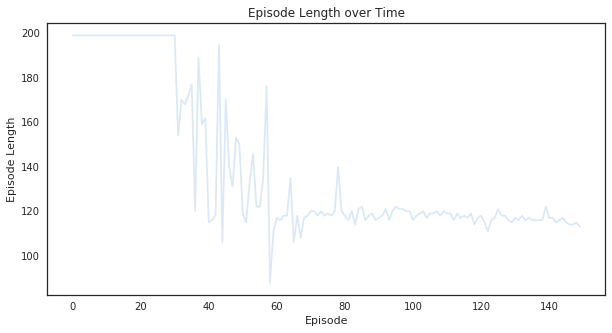

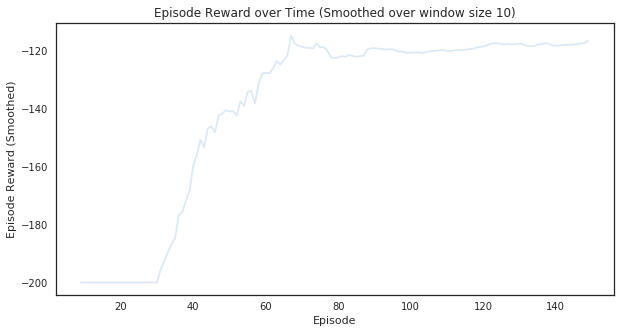

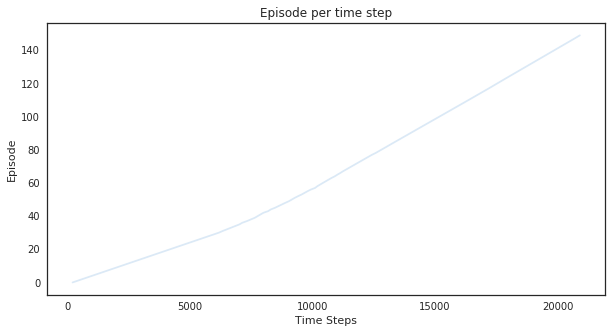

(<matplotlib.figure.Figure at 0x7f4b996bd860>,
 <matplotlib.figure.Figure at 0x7f4b9b7ccda0>)

In [5]:
phi = phi_gaus
p = p_gaus

mdp_solver = LinearQ3(env=env,
                      phi=phi,
                      p=p,
                      action_list=action_list,
                      n_episode=150,
                      epsilon=0.0,
                      epsilon_decay=1.00,
                      gamma=gamma)

pi_expert, stats = mdp_solver.solve(reward_fn=None)
plotting.plot_cost_to_go_mountain_car(env, pi_expert._estimator)
plotting.plot_episode_stats(stats, smoothing_window=10)

## generate trajectories under expert policy (=D)

In [6]:
class NearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        c = 0
        return 0 if v <= c else 2

class AntiClimacticPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        c = 0
        if  v <= 0: 
            return 0
        else:
            if -0.9 < pos < -0.4:
                # slowdown
                return 0
            return 2
    
class OppositeNearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        c = np.random.uniform(-0.1, 0.1)
        return 0 if v > c else 2
    
pi_near = NearExpertPolicy()
pi_near_ops = OppositeNearExpertPolicy()
pi_random = RandomPolicy2(action_list)


In [15]:
# mixed training set
pi_list = [pi_random, pi_near_ops, pi_near, pi_expert]
mix_ratio = [0.1, 0.1, 0.1, 0.7]
sample_size = 100

D = sim.simulate_mixed(env, pi_list, sample_size, mix_ratio)
D_mat = Simulator.to_matrix(D)

# pure expert

D_pure = sim.simulate(pi_expert, 1, 30)
D_pure_mat = Simulator.to_matrix(D_pure)


Step 118 @ Episode 30/30 (-117.0)

## visualize the traning datasets
- mixed training set
- purely expert training dataset
- full coverage training dataset

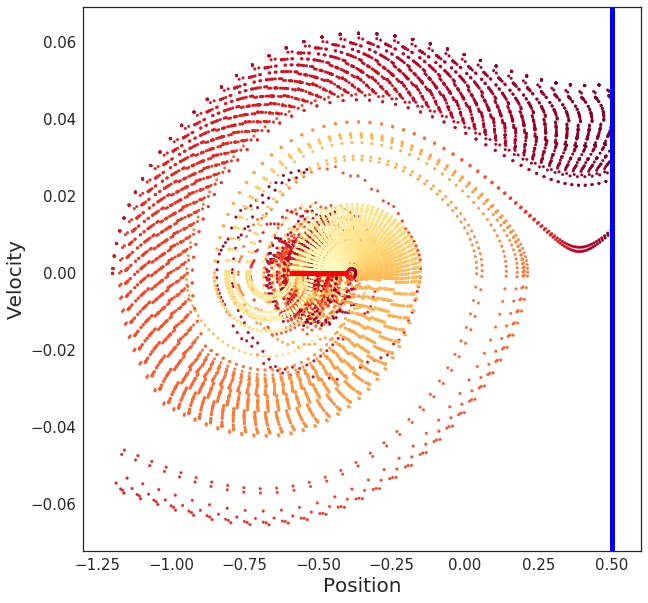

In [16]:
plot_trajectory_mountain_car(D)

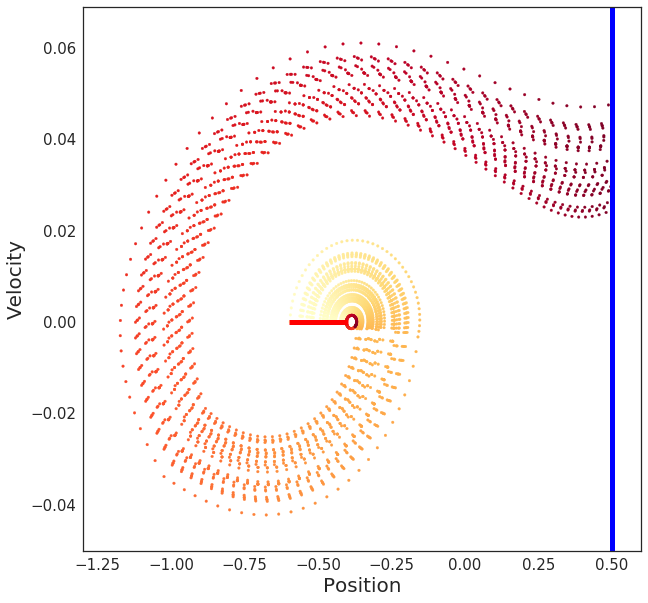

In [17]:
plot_trajectory_mountain_car(D_pure)

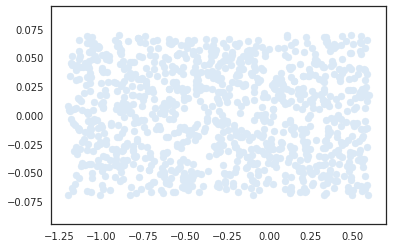

In [18]:
states=np.array([env.observation_space.sample() for _ in range(1000)])
plt.scatter(states[:, 0], states[:, 1])

def generate_state_samples(env, pi, n_sample=1000):
    """
    a hacky way to cover most state space uniformly
    """
    D = []
    states=np.array([env.observation_space.sample() for _ in range(n_sample)])
    for s in states:
        env.reset(s)
        a = pi.choose_action(s)
        s_next, r, done, _ = env.step(a)
        # one transition = one episode
        D.append([[s, a, r, s_next, done]])
    return D
    
D_fake = generate_state_samples(env, pi_random, 10000)
D_fake_mat = Simulator.to_matrix(D_fake)

## study the behavior of $\gamma$
- small gamma (high variance) gives sparse coding but requires less centers (components)
- large gamma (low variance) gives dense coding but requires more centers (components)
- components: need enough (also need to consider gamma) numbers to cover the state space 

In [ ]:
def plot_gamma(gammas):
    for g in gammas:
        components = [3]
        gamma_list = [g]
        p_rbf =  int(np.sum(components)) * n_action
        q_rbf = int(np.sum(components)) * n_action
        #states = np.array([env.observation_space.sample() for x in range(1000)])
        s = np.vstack(D_mat[:, 0])
        samples = s
        phi_rbf = RBFKernel2(samples, n_action, p_rbf, components, gamma_list, include_action).transform
        phis = np.array([phi_rbf(s, 1).flatten() for s in states])

        plt.figure()
        plt.title("gamma={}".format(g))
        plt.xlim(-1.0, 1.0)
        plt.hist(phis[phis != 0])
gammas = [0.05, 0.5, 1.0, 2.0, 5.0, 50.0]
plot_gamma(gammas)

### cross validate for basis features
- to avoid underdtermined system
- the smaller n_component is, the smaller the number of gammas, the more likely the linear system is stable
- however, a full rank system may not give a good policy
- if n_component is small like 5, a very high gamma is necessary to cover sufficiently large state space
- if phi(s), small n_component is enough, if phi(s,a) larger n_component and more powerful stuffi is needed
- gamma should be larger (larger variance)
- n_component should be small (but not rich)
- gamma clearly heavily influences basis features and tehrefore the rank of A
- reward function influences the norm scale
- mix small and large gammas (why?)
- perhaps n_component for each gamma should be different?

In [ ]:
# IMPORTANT DECISION?
#samples = states 
#samples = np.vstack(D_fake_mat[:, 0])
p#hi_gaus = GaussianKernel(samples, n_action, p_gaus, n_component, include_action, add_bias, standardized).transform

## Solve MountainCar-v0 with LSPI


In [24]:
def solve_mountain_car(p, phi, gamma, precision, eps, D, reward_fn=None, max_iter=10):  
    W_0 = np.random.rand(p)
    lspi = LSPI(D=D,
                action_list=action_list,
                p=p,
                phi=phi,
                gamma=gamma,
                precision=precision,
                eps=eps,
                W_0=W_0,
                reward_fn=reward_fn,
                max_iter=max_iter)

    W, w_list = lspi.solve()
    return W, w_list

# mixed

#W_linear = solve_mountain_car(p_linear, phi_linear, gamma, precision, eps, D_mat, None, 10)
#w_rbf, w_list = solve_mountain_car(p_rbf, phi_rbf, gamma, precision, eps, D_mat, None, 15)
#w_gaus, w_list = solve_mountain_car(p_gaus, phi_gaus, gamma, precision, eps, D_mat, reward_fn3, 3)

# pure

#W_linear = solve_mountain_car(p_linear, phi_linear, gamma, precision, eps, D_mat, None, 10)
#w_rbf, w_list = solve_mountain_car(p_rbf, phi_rbf, gamma, precision, eps, D_mat, None, 15)
#w_gaus, w_list = solve_mountain_car(p_gaus, phi_gaus, gamma, precision, eps, D_pure_mat, None, 3)


# fake

#W_linear = solve_mountain_car(p_linear, phi_linear, gamma, precision, eps, D_mat, None, 10)
#w_rbf, w_list = solve_mountain_car(p_rbf, phi_rbf, gamma, precision, eps, D_mat, None, 15)
w_gaus, w_list = solve_mountain_car(p_gaus, phi_gaus, gamma, precision, eps, D_fake_mat, None, 5)

INFO:root:fitting D of the dimension:
(10000, 5)
INFO:root:lspi norm 72635.92269631934
INFO:root:lspi norm 3915.228624980752
INFO:root:lspi norm 2459.904823663697
INFO:root:lspi norm 946.6959553872856
INFO:root:lspi norm 40.303494427131085


## check the policies returned by LSPI

Step 198 @ Episode 30/30 (-200.0)

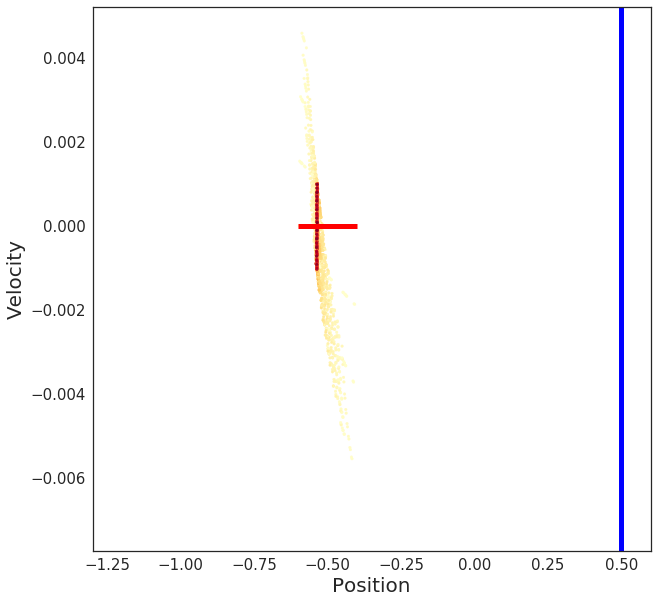

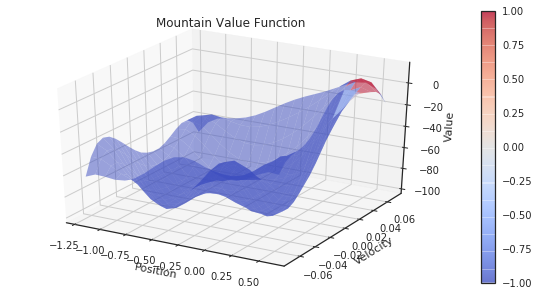

Step 85 @ Episode 30/30 (-154.0))

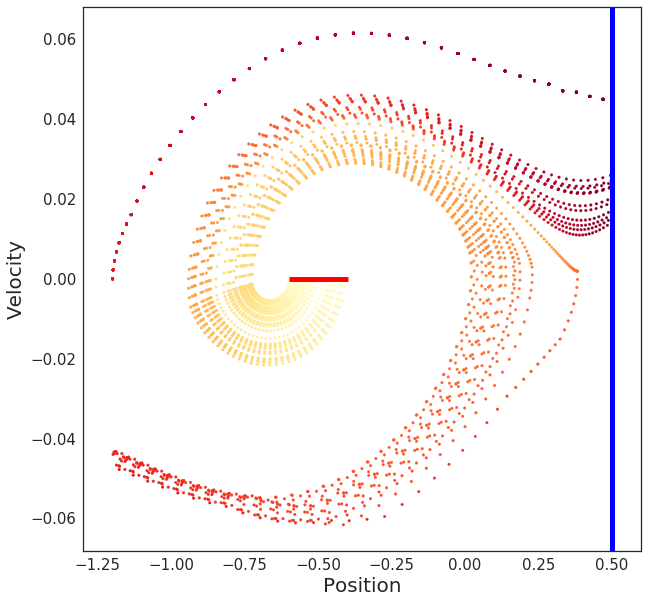

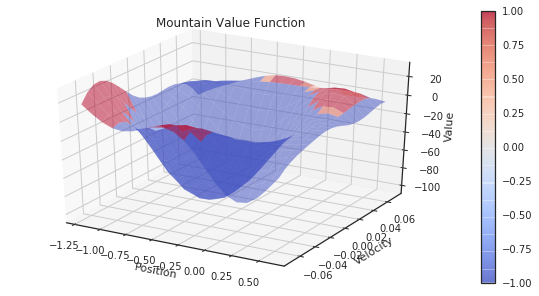

Step 149 @ Episode 30/30 (-88.0))

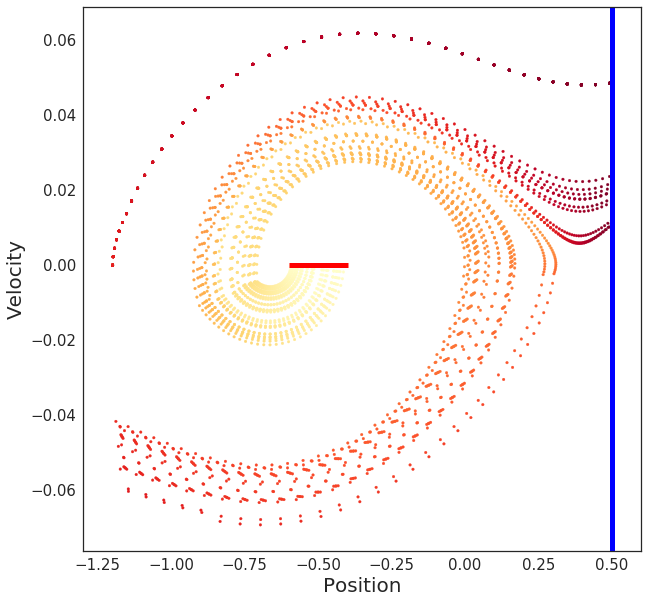

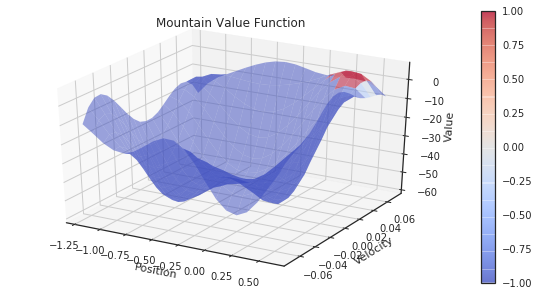

Step 83 @ Episode 30/30 (-95.0)))

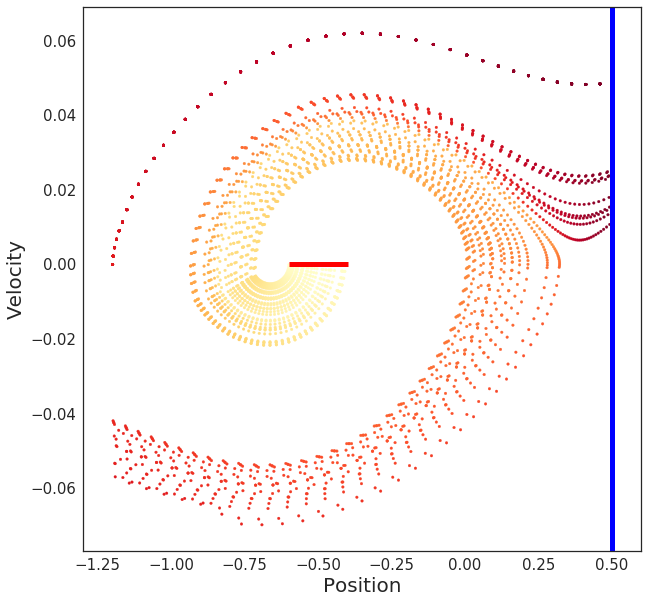

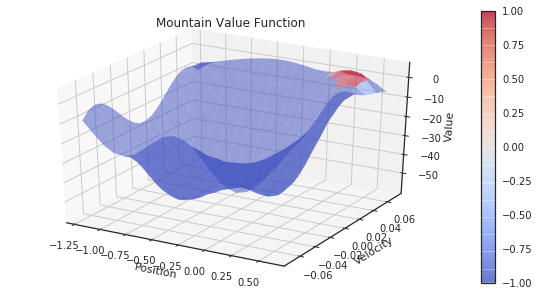

Step 86 @ Episode 30/30 (-148.0))

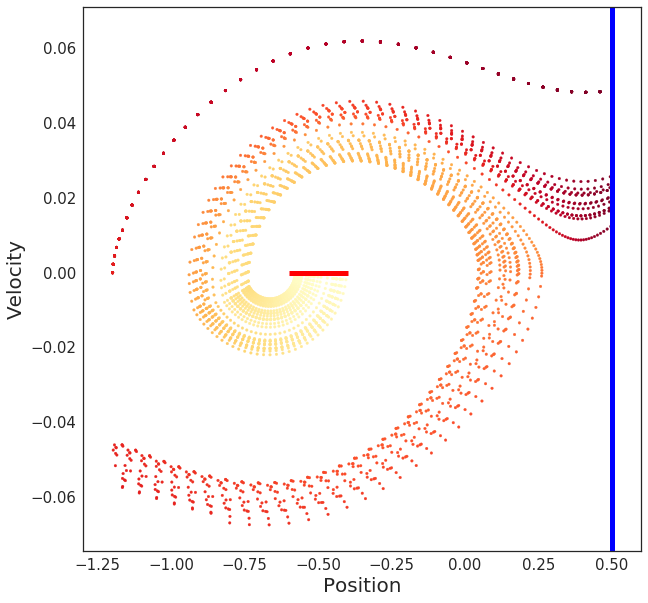

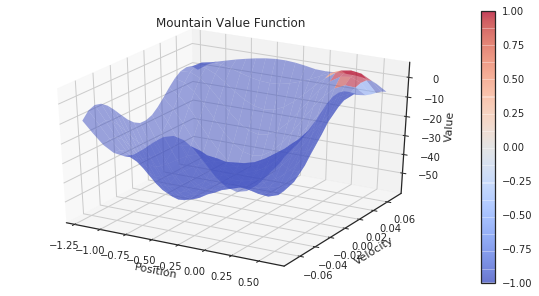

In [25]:
phi = phi_gaus

for w in w_list: 
    pi_star = LinearQ2(action_list=action_list, phi=phi, W=w)
    #pi_star = LinearQ2(action_list=action_list, phi=phi_linear, W=W_linear)
    D_star, stats = sim.simulate(pi=pi_star, n_trial=1, n_episode=30, return_stats=True)
    plot_trajectory_mountain_car(D_star)    
    plot_cost_to_go_mountain_car(env, pi_star)
    #plot_episode_stats(stats, smoothing_window=5)

# study the sensitivity of LSPI to reward functions
- the default reward function is -1 always
- generally, lspi norm varies with reward function choice (why?)

In [26]:
# preprocess reward if needed
def reward_fn1(s, a):
    pos, v = s
    return 1 if pos > 0.45 else 0

def reward_fn2(s, a):
    pos, v = s
    return 10*(pos + 0.6)**2

def reward_fn3(s, a):
    pos, v = s
    if pos < -0.75:
        return 0
    elif pos < 0.25:
        return -1
    else:
        return 100


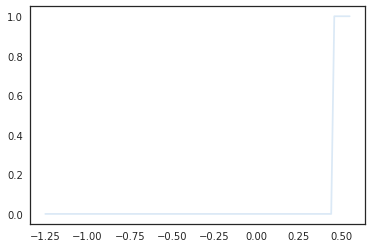

In [27]:
xx = np.linspace(-1.25, 0.55, 100)
r = [reward_fn1([x, 0], 0) for x in xx]
plt.plot(xx, r)

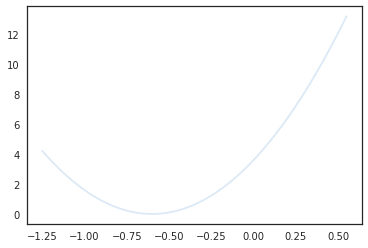

In [28]:
xx = np.linspace(-1.25, 0.55, 100)
r = [reward_fn2([x, 0], 0) for x in xx]
plt.plot(xx, r)

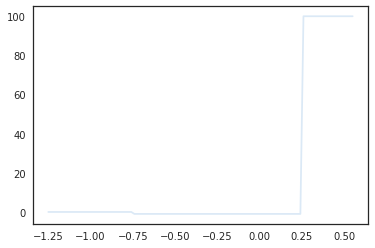

In [29]:
xx = np.linspace(-1.25, 0.55, 100)
r = [reward_fn3([x, 0], 0) for x in xx]
plt.plot(xx, r)

(array([  546.,  1045.,  1022.,  3125.,  4389.,  1939.,   457.,   437.,
          424.,   402.]),
 array([-1.2       , -1.03007675, -0.86015349, -0.69023024, -0.52030698,
        -0.35038373, -0.18046047, -0.01053722,  0.15938604,  0.32930929,
         0.49923255]),
 <a list of 10 Patch objects>)

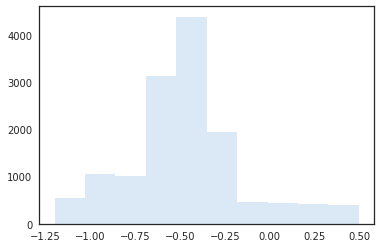

In [30]:
s = np.vstack(D_mat[:, 0])
a = np.vstack(D_mat[:, 1])
r = np.vstack([reward_fn2(s,a) for s, a in zip(s, a)])
plt.hist(s[:, 0])

## open questions
- what region is crucial?
- just uniformly important?
- does reward function change behavior of LSPI at all?
- why are behaviors w.r.t basis feature for online vs. batch setting so different? 